In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import lightgbm as lgb
import hyperopt
import random
import time
import itertools
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('C:/Users/DFursov/Documents/WORK_FILTER_FOR_ABTR_30NOV18.csv', sep = ';', nrows = 700000, encoding = 'cp1251')

In [3]:
# Определение технических функций для очистки таблиц

def DelTargetColumns(df, target):
    cols = []
    for i in df.columns:
        if i.find('tar_') != -1:
            cols.append(i)
    if target in df.columns:
        cols.remove(target)
    else:
        raise NameError('''This column don't exist in pd.DataFrame''')
    df = df.drop(cols, axis = 1)
    return df

def DelObjectColumns(df):
    cols = []
    for i in df.columns:
        if df[i].dtype == 'O':
            cols.append(i)
    df = df.drop(cols, axis = 1)
    return df

In [4]:
for i in df.columns:
    print(i)

A_ACTIVE_BALANCE_FLG
A_AGE
A_CURR_BALANCE
A_DAYS_LASTCHANGE_BALANCE
A_DAYS_NEXTBIRTH
A_DAYS_VIP_12M
A_DAYS_VIP_1M
A_DAYS_VIP_3M
A_DAYS_VIP_6M
A_DAYS_VIP_END
A_SEX
A_VIP_FLG
bon_amo_acc_avg_12m
bon_amo_acc_avg_1m
bon_amo_acc_avg_1to12
bon_amo_acc_avg_1to3
bon_amo_acc_avg_1to6
bon_amo_acc_avg_3m
bon_amo_acc_avg_3to12
bon_amo_acc_avg_3to6
bon_amo_acc_avg_6m
bon_amo_acc_avg_6to12
bon_amo_acc_max_12m
bon_amo_acc_max_1m
bon_amo_acc_max_1to12
bon_amo_acc_max_1to3
bon_amo_acc_max_1to6
bon_amo_acc_max_3m
bon_amo_acc_max_3to12
bon_amo_acc_max_3to6
bon_amo_acc_max_6m
bon_amo_acc_max_6to12
bon_amo_acc_min_12m
bon_amo_acc_min_1m
bon_amo_acc_min_3m
bon_amo_acc_min_6m
bon_amo_acc_std_12m
bon_amo_acc_std_1m
bon_amo_acc_std_3m
bon_amo_acc_std_6m
bon_amo_acc_sum_12m
bon_amo_acc_sum_1m
bon_amo_acc_sum_1to12
bon_amo_acc_sum_1to3
bon_amo_acc_sum_1to6
bon_amo_acc_sum_3m
bon_amo_acc_sum_3to12
bon_amo_acc_sum_3to6
bon_amo_acc_sum_6m
bon_amo_acc_sum_6to12
bon_amo_spn_avg_12m
bon_amo_spn_avg_1m
bon_amo_spn_avg_

itm_cnt_sum_1m_C022_wash
itm_cnt_sum_1m_C023_hairstyle
itm_cnt_sum_1m_C026_tights
itm_cnt_sum_1m_C028_soap
itm_cnt_sum_1m_C032_clothes
itm_cnt_sum_1m_C033_airfresh
itm_cnt_sum_1m_C034_frag
itm_cnt_sum_1m_C041_hygiene
itm_cnt_sum_1m_C045_haircare
itm_cnt_sum_1m_C046_facecare
itm_cnt_sum_1m_C048_oralcare
itm_cnt_sum_1m_C049_handcare
itm_cnt_sum_1m_C050_bodycare
itm_cnt_sum_1m_C053_houseitms
itm_cnt_sum_1m_C054_cleaning
itm_cnt_sum_1m_hairmask
itm_cnt_sum_1m_soap
itm_cnt_sum_1m_softener
itm_cnt_sum_1m_toothbrsh
itm_cnt_sum_3m_C003_bijout
itm_cnt_sum_3m_C004_shave
itm_cnt_sum_3m_C005_depil
itm_cnt_sum_3m_C009_bath
itm_cnt_sum_3m_C011_BAD
itm_cnt_sum_3m_C012_paper
itm_cnt_sum_3m_C014_galantr
itm_cnt_sum_3m_C015_deodorant
itm_cnt_sum_3m_C016_make
itm_cnt_sum_3m_C017_kids
itm_cnt_sum_3m_C018_pets
itm_cnt_sum_3m_C020_haircolor
itm_cnt_sum_3m_C022_wash
itm_cnt_sum_3m_C023_hairstyle
itm_cnt_sum_3m_C026_tights
itm_cnt_sum_3m_C028_soap
itm_cnt_sum_3m_C032_clothes
itm_cnt_sum_3m_C033_airfresh
itm_c

In [5]:
target = 'tar_14d'
df = DelTargetColumns(df, target)
df = DelObjectColumns(df)

In [6]:
train_columns = list(df.columns)
train_columns.remove(target)
y = df[target]
X = df[train_columns]

In [7]:
# Откладываем 20% данных для тестовой выборки. Валидируемся кросс-валидацией на 5 фолдов на train-наборе

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
# Убираем выбросы из данных

del df
smp = SimpleImputer(strategy = 'median')
x_train = smp.fit_transform(x_train)
x_test = smp.transform(x_test)
iso_forest = IsolationForest(random_state = 42, bootstrap = True)
outliers = iso_forest.fit_predict(x_train, y_train)
x_train = pd.DataFrame(data = x_train, columns = train_columns)
x_train['outliers'] = outliers
x_train = x_train[x_train['outliers'] == 1]
x_train = x_train.drop('outliers', axis = 1)
y_train = y_train[outliers == 1]
x_train.replace(-np.inf, 0, inplace = True)
x_train.replace(np.inf, 0, inplace = True)

### Неоткалиброванный классификатор + hyperopt

In [10]:
# Пространство перебора гиперпараметров для hyperopt

space ={
        'boosting_type': hp.choice( 'boosting_type', ['gbdt', 'dart' ] ),
        'max_depth': scope.int(hp.quniform("max_depth", 4, 9, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 10)),
        'num_leaves': scope.int(hp.quniform ('num_leaves', 20, 100, 1)),
        'min_data_in_leaf':  scope.int(hp.quniform ('min_data_in_leaf', 10, 100, 1)),
        'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
        'learning_rate': hp.loguniform('learning_rate', -6.9, -0.5),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', 0, 2.3),
        'lambda_l1': hp.uniform('lambda_l1', 1e-4, 1e-6 ),
        'lambda_l2': hp.uniform('lambda_l2', 1e-4, 1e-6 ),
        'seed': hp.randint('seed',2000000)
       }

In [11]:
# Целевая функция для hyperopt (по ней оптимизируемся)

def objective(space):
    clf = lgb.LGBMClassifier(**space)
    current_score = cross_val_score(clf, x_train, y_train, cv = 5, scoring = make_scorer(roc_auc_score, needs_proba = True)).mean()
    return -current_score

In [14]:
# Оптимизация hyperopt

best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 10)

100%|███████████████████████████████████████████████| 10/10 [3:30:23<00:00, 957.39s/it, best loss: -0.7717812367963373]


In [15]:
best # наилучшие гиперпараметры

{'bagging_fraction': 0.8597471622559327,
 'boosting_type': 1,
 'feature_fraction': 0.9008594239897927,
 'lambda_l1': 3.272108298454388e-05,
 'lambda_l2': 4.054004212823425e-05,
 'learning_rate': 0.09002035204434929,
 'max_depth': 4.0,
 'min_data_in_leaf': 69.0,
 'min_sum_hessian_in_leaf': 4.21643503434449,
 'n_estimators': 720.0,
 'num_leaves': 28.0,
 'seed': 1364477}

In [18]:
# определеяем модель с подобранными гиперпараметрами
lgb_model = lgb.LGBMClassifier(boosting_type = 'dart', num_leaves = 28, max_depth = 4, learning_rate = 0.09,
                              n_estimators = 720, feature_fraction = 0.9, lambda_l1 = 3.27, lambda_l2 = 4.05,
                              min_data_in_leaf = 69, min_sum_hessian_in_leaf = 4.21,
                              bagging_fraction = 0.859747, seed = 1364477)

In [19]:
lgb_model.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.859747, boosting_type='dart',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        importance_type='split', lambda_l1=3.27, lambda_l2=4.05,
        learning_rate=0.09, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=69, min_split_gain=0.0,
        min_sum_hessian_in_leaf=4.21, n_estimators=720, n_jobs=-1,
        num_leaves=28, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, seed=1364477, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [22]:
# предсказания для трейна/теста
lgb_predict_train = lgb_model.predict_proba(x_train)[:,1]
lgb_predict_test = lgb_model.predict_proba(x_test)[:,1]

In [80]:
lgb_pred = pd.Series(lgb_predict_test)
lgb_pred = lgb_pred.apply(lambda x: 1 if x >= 0.26 else 0)

In [81]:
print(accuracy_score(y_test, lgb_pred))
print(recall_score(y_test, lgb_pred))
print(precision_score(y_test, lgb_pred))

0.8120428571428572
0.6165904637491836
0.03539424843462937


In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lgb_pred)

array([[112742,  25727],
       [   587,    944]], dtype=int64)

In [86]:
rc = list()
prob = 0
while prob < 1:
    prob += 0.01
    lgb_pred = pd.Series(lgb_predict_test)
    lgb_pred = lgb_pred.apply(lambda x: 1 if x >= prob else 0)
    rc.append(recall_score(y_test, lgb_pred))

In [91]:
prec = list()
prob = 0
while prob < 1:
    prob += 0.01
    lgb_pred = pd.Series(lgb_predict_test)
    lgb_pred = lgb_pred.apply(lambda x: 1 if x >= prob else 0)
    prec.append(precision_score(y_test, lgb_pred))

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 1440x720 with 0 Axes>

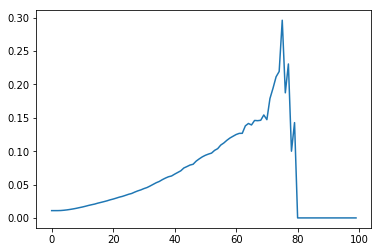

<Figure size 1440x720 with 0 Axes>

In [93]:
plt.plot(prec)
plt.figure(figsize = (20, 10))

<Figure size 1440x720 with 0 Axes>

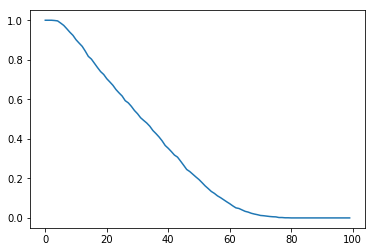

<Figure size 1440x720 with 0 Axes>

In [94]:
plt.plot(rc)
plt.figure(figsize = (20, 10))

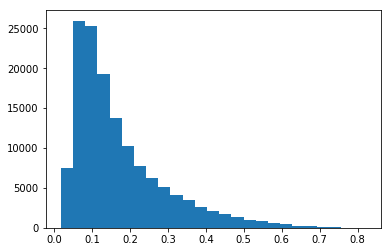

In [65]:
import matplotlib.pyplot as plt
plt.hist(lgb_predict_test, bins = 25)
plt.show()

In [40]:
from sklearn.metrics import f1_score

In [47]:
print(f1_score(y_test, lgb_pred))

0.07796467225788314


In [23]:
print(roc_auc_score(y_train, lgb_predict_train))
print(roc_auc_score(y_test, lgb_predict_test))

0.8418388761106084
0.789135517763141


In [25]:
from sklearn.externals import joblib
joblib.dump(lgb_model, 'lgb.pkl')

['lgb.pkl']

In [26]:
bst = joblib.load('lgb.pkl')

In [98]:
imp = pd.Series(lgb_model.feature_importances_, index = train_columns)

In [104]:
from sklearn.calibration import calibration_curve

In [105]:
fop, mpv = calibration_curve(y_test, lgb_predict_test, n_bins = 10)

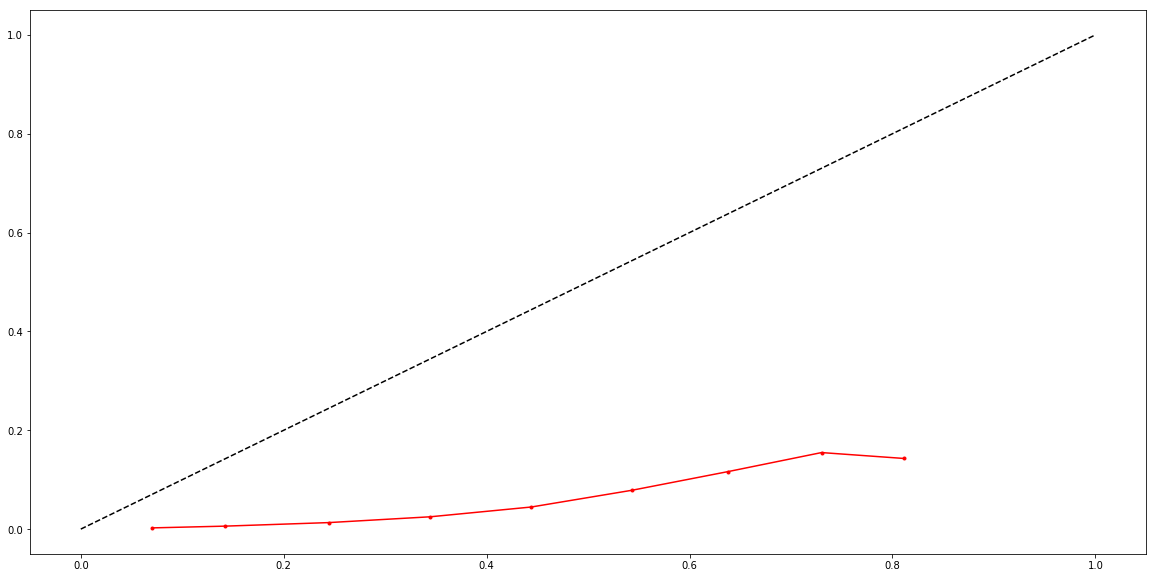

In [106]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black')
plt.plot(mpv, fop, marker = '.', color = 'red')

### Откалиброванный классификатор

In [108]:
from sklearn.calibration import CalibratedClassifierCV
lgb_model2 = lgb.LGBMClassifier(boosting_type = 'dart', num_leaves = 28, max_depth = 4, learning_rate = 0.09,
                              n_estimators = 720, feature_fraction = 0.9, lambda_l1 = 3.27, lambda_l2 = 4.05,
                              min_data_in_leaf = 69, min_sum_hessian_in_leaf = 4.21,
                              bagging_fraction = 0.859747, seed = 1364477)

lgb_calibrated = CalibratedClassifierCV(base_estimator = lgb_model2, method = 'isotonic', cv = 5)

In [109]:
lgb_calibrated.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.859747, boosting_type='dart',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        importance_type='split', lambda_l1=3.27, lambda_l2=4.05,
        learning_rate=0.09, max_depth=4, min_child_samples=20,
        min_child_weig...a=0.0, seed=1364477, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
            cv=5, method='isotonic')

In [113]:
pred_calibrated = lgb_calibrated.predict_proba(x_test)[:, 1]

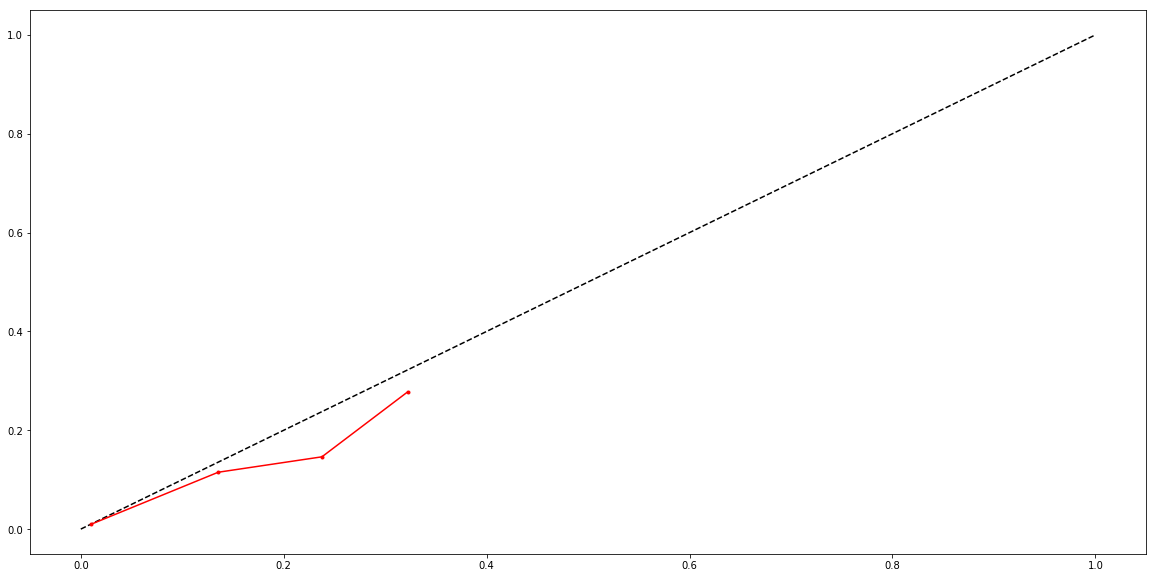

In [158]:
fop_calibrated, mpv_calibrated = calibration_curve(y_test, pred_calibrated, n_bins = 10)
plt.figure(figsize = (20, 10))
plt.plot([0,1], [0,1], linestyle = '--', color = 'black')
plt.plot(mpv_calibrated, fop_calibrated, marker = '.', color = 'red')

In [118]:
joblib.dump(lgb_calibrated, 'lgb_calibrated.pkl')

['lgb_calibrated.pkl']

In [116]:
print(roc_auc_score(y_test, pred_calibrated))

0.7911727562985269

In [134]:
lgb_pred2 = pd.Series(pred_calibrated)
lgb_pred2 = lgb_pred2.apply(lambda x: 1 if x >= 0.06 else 0)
print(accuracy_score(y_test, lgb_pred2))
print(recall_score(y_test, lgb_pred2))
print(precision_score(y_test, lgb_pred2))

0.9669928571428571
0.22730241672109733
0.0919175911251981


In [135]:
confusion_matrix(y_test, lgb_pred2)

array([[135031,   3438],
       [  1183,    348]], dtype=int64)

In [163]:
pred_calibrated.max()

0.3268398268398269

(array([1.02503e+05, 1.89320e+04, 6.97200e+03, 3.67600e+03, 2.18300e+03,
        1.31900e+03, 7.77000e+02, 4.95000e+02, 3.41000e+02, 2.38000e+02,
        1.71000e+02, 1.53000e+02, 1.23000e+02, 1.02000e+02, 7.70000e+01,
        5.60000e+01, 5.80000e+01, 5.30000e+01, 5.00000e+01, 3.70000e+01,
        2.50000e+01, 2.20000e+01, 1.90000e+01, 2.10000e+01, 1.90000e+01,
        8.00000e+00, 2.00000e+01, 6.00000e+00, 4.00000e+00, 9.00000e+00]),
 array([0.        , 0.01089466, 0.02178932, 0.03268398, 0.04357864,
        0.0544733 , 0.06536797, 0.07626263, 0.08715729, 0.09805195,
        0.10894661, 0.11984127, 0.13073593, 0.14163059, 0.15252525,
        0.16341991, 0.17431457, 0.18520924, 0.1961039 , 0.20699856,
        0.21789322, 0.22878788, 0.23968254, 0.2505772 , 0.26147186,
        0.27236652, 0.28326118, 0.29415584, 0.30505051, 0.31594517,
        0.32683983]),
 <a list of 30 Patch objects>)

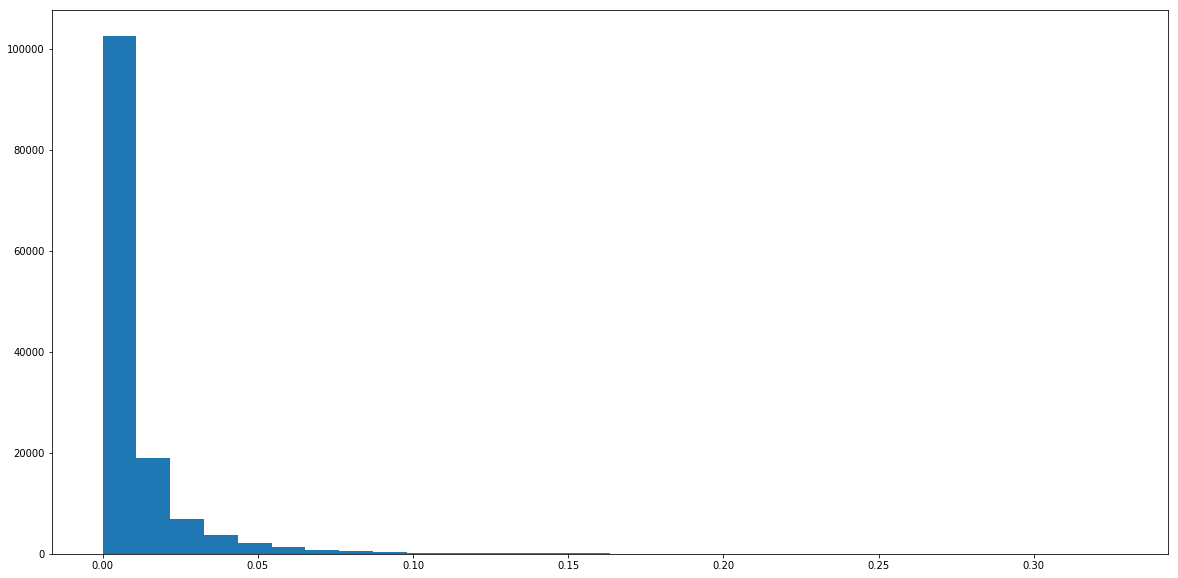

In [159]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 0], bins = 30)

In [152]:
pred_calibrated[y_test == 1].mean()

0.04309347502245069

(array([478., 263., 159., 139.,  96.,  81.,  71.,  41.,  26.,  26.,  19.,
         24.,  18.,   9.,   8.,  14.,   4.,  10.,  12.,   3.,   2.,   3.,
          6.,   5.,   4.,   2.,   3.,   0.,   0.,   5.]),
 array([0.00049339, 0.0113716 , 0.02224982, 0.03312803, 0.04400624,
        0.05488446, 0.06576267, 0.07664089, 0.0875191 , 0.09839732,
        0.10927553, 0.12015375, 0.13103196, 0.14191018, 0.15278839,
        0.16366661, 0.17454482, 0.18542304, 0.19630125, 0.20717947,
        0.21805768, 0.22893589, 0.23981411, 0.25069232, 0.26157054,
        0.27244875, 0.28332697, 0.29420518, 0.3050834 , 0.31596161,
        0.32683983]),
 <a list of 30 Patch objects>)

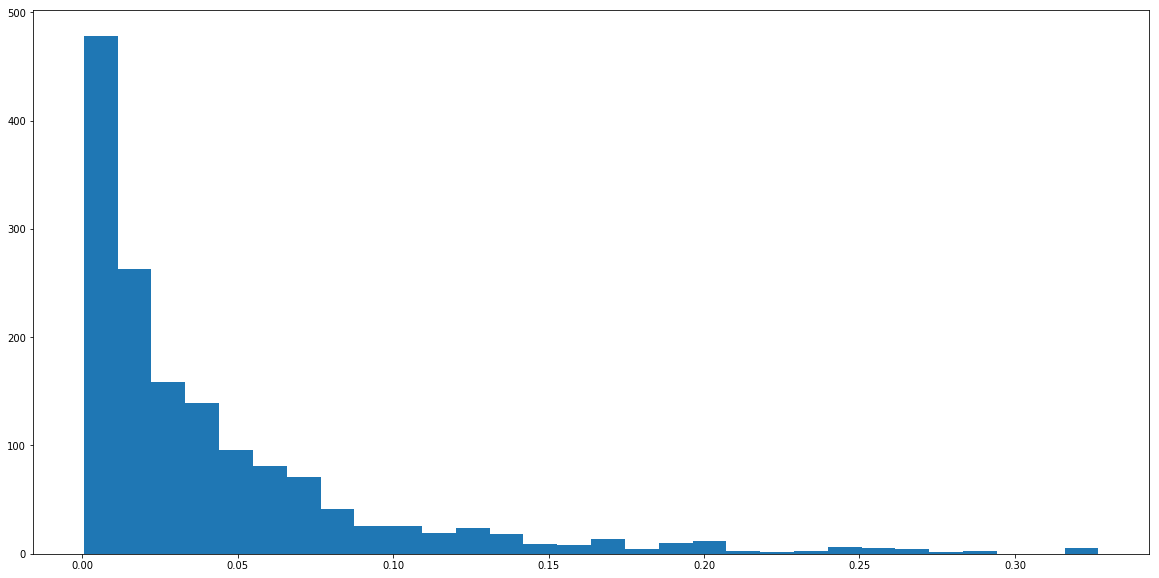

In [155]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 1], bins = 30)

(array([1.1469e+05, 1.3717e+04, 4.9060e+03, 2.2720e+03, 1.0220e+03,
        5.9100e+02, 3.3100e+02, 2.3100e+02, 1.6800e+02, 1.3400e+02,
        8.6000e+01, 8.1000e+01, 7.3000e+01, 3.9000e+01, 3.4000e+01,
        2.8000e+01, 2.5000e+01, 2.2000e+01, 1.0000e+01, 9.0000e+00]),
 array([0.        , 0.01634199, 0.03268398, 0.04902597, 0.06536797,
        0.08170996, 0.09805195, 0.11439394, 0.13073593, 0.14707792,
        0.16341991, 0.1797619 , 0.1961039 , 0.21244589, 0.22878788,
        0.24512987, 0.26147186, 0.27781385, 0.29415584, 0.31049784,
        0.32683983]),
 <a list of 20 Patch objects>)

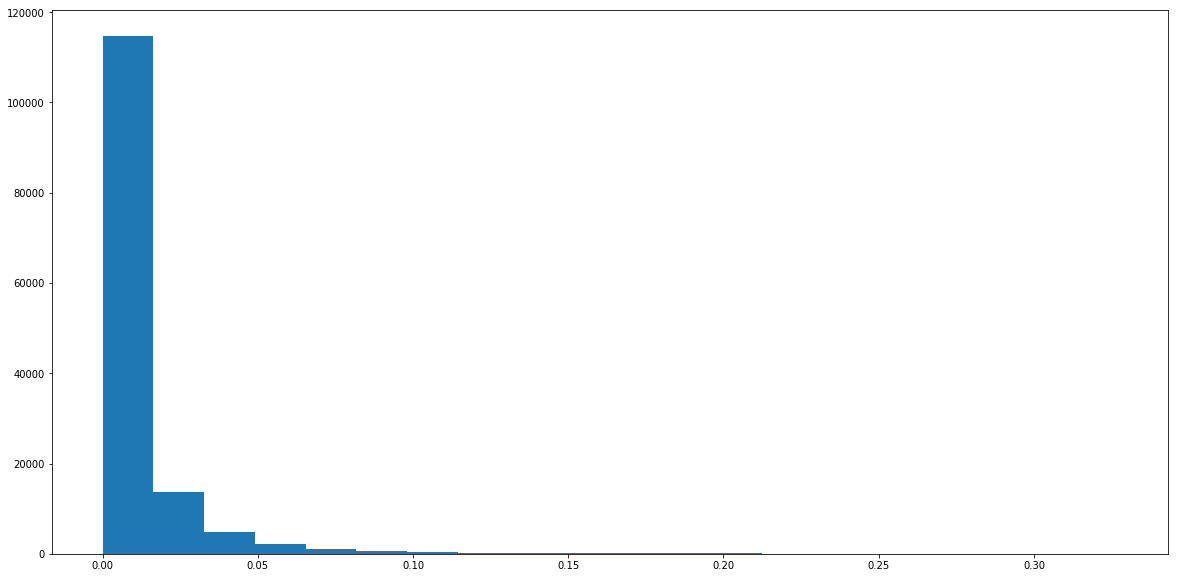

In [154]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 0], bins = 20)

In [138]:
pred_calibrated[pred_calibrated > 0.06].mean()

0.10504570147918793

In [132]:
fsc = list()
best_prob = 0
max_f = 0
prob = 0
while prob < 0.3:
    prob += 0.01
    lgb_pred2 = pd.Series(pred_calibrated)
    lgb_pred2 = lgb_pred2.apply(lambda x: 1 if x >= prob else 0)
    fsc.append(f1_score(y_test, lgb_pred2))
    if f1_score(y_test, lgb_pred2) > max_f:
        best_prob = prob
        max_f = f1_score(y_test, lgb_pred2) 

In [149]:
print(best_prob)

0.060000000000000005


In [161]:
imp = pd.Series(lgb_model.feature_importances_, index = train_columns)

In [165]:
imp.sort_values(ascending = False).to_csv('importances.csv', index = True, sep = ';')